In [3]:
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Imports the neighborhoods GDF
neighborhood_url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhood_gdf = geopandas.read_file(neighborhood_url).set_index('hood')

#Grabs Sean's data from the WPRDC (Will probably be redone to just store the stuff in the files)
crashes_2020_url = "https://data.wprdc.org/datastore/dump/514ae074-f42e-4bfb-8869-8d8c461dd824"
crashes_2019_url = "https://data.wprdc.org/datastore/dump/cb0a4d8b-2893-4d20-ad1c-47d5fdb7e8d5"
crashes_2018_url = "https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/48f30bee-e404-4cf5-825b-b0da3c975e45/download/crash-data-2018.csv"
crashes_2017_url = "https://data.wprdc.org/datastore/dump/bf8b3c7e-8d60-40df-9134-21606a451c1a"
crashes_2016_url = "https://data.wprdc.org/datastore/dump/9ccea350-e062-45e2-ade5-45e9378f40d2"
crashes_df=pd.concat([pd.read_csv(crashes_2020_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2019_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2018_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2017_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2016_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']]
                         ],ignore_index=True)
crashes_gdf = geopandas.GeoDataFrame(crashes_df, geometry=geopandas.points_from_xy(crashes_df.DEC_LONG, crashes_df.DEC_LAT, crs=4326))
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212

#Reads Alex's fire incidents csv
fire_data = pd.read_csv("Fire_Alarm.csv")

#Reads Dom's arrest csv
arrest = pd.read_csv("arrests.csv")

In [35]:
#Adds column for Dom's arrests labeled 'arrests'
filterarrest = arrest.groupby("INCIDENTNEIGHBORHOOD")["OFFENSES"].count()
try:
    neighborhood_gdf.insert(0,"arrests",filterarrest)
except ValueError:
    neighborhood_gdf['arrests'] = filterarrest
print(filterarrest.index)

Index(['Allegheny Center', 'Allegheny West', 'Allentown', 'Arlington',
       'Arlington Heights', 'Banksville', 'Bedford Dwellings', 'Beechview',
       'Beltzhoover', 'Bloomfield', 'Bluff', 'Bon Air', 'Brighton Heights',
       'Brookline', 'California-Kirkbride', 'Carrick',
       'Central Business District', 'Central Lawrenceville',
       'Central North Side', 'Central Northside', 'Central Oakland',
       'Chartiers City', 'Chateau', 'Crafton Heights', 'Crawford-Roberts',
       'Duquesne Heights', 'East Allegheny', 'East Carnegie', 'East Hills',
       'East Liberty', 'Elliott', 'Esplen', 'Fairywood', 'Fineview',
       'Friendship', 'Garfield', 'Glen Hazel', 'Golden Triangle/Civic Arena',
       'Greenfield', 'Hays', 'Hazelwood', 'Highland Park', 'Homewood North',
       'Homewood South', 'Homewood West', 'Knoxville', 'Larimer',
       'Lincoln Place', 'Lincoln-Lemington-Belmar', 'Lower Lawrenceville',
       'Manchester', 'Marshall-Shadeland', 'Middle Hill', 'Morningside',
   

In [10]:
#Adds column for Alex's fire incidents labeled 'fires'
neighbourhood_dictionary = {}
name = ""
counter = 0
neighbourhood_counter = 0
for index, row in fire_data.iterrows():
    neighborhood = row["neighborhood"]
    time = row["alarm_time"]
    if(type(time) == str):
        if(time.startswith("2016") or time.startswith("2017") or time.startswith("2018") or time.startswith("2019") or time.startswith("2020")):
            if(neighborhood not in neighbourhood_dictionary.keys()):
                neighbourhood_dictionary.update({neighborhood: [neighborhood, 1]})
                continue
            counter = neighbourhood_dictionary[neighborhood]
            counter[1] += 1
            neighbourhood_dictionary.update({neighborhood: counter})
neighborhood_df = pd.DataFrame.from_dict(neighbourhood_dictionary, orient = "index")
neighborhood_df.columns = ["Neighbourhood", "Number of Incidents"]
neighborhood_df = neighborhood_df.dropna()
neighborhood_df = neighborhood_df.drop(index=['Mount Oliver Borough'])
try:
    neighborhood_gdf.insert(1,"fires", neighborhood_df['Number of Incidents'])
except ValueError:
    neighborhood_gdf['fires'], neighborhood_df['Number of Incidents']

In [11]:
#Adds column for Sean's crashes labeled 'crashes'
pittsburgh_crashes = geopandas.GeoDataFrame(columns=crashes_gdf.columns.append(pd.Index(['hood'])), geometry='geometry', crs=4326)
crash_count = []
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        count = bool_crashes.value_counts().loc[True]
    except KeyError:
        count = 0
    crash_count.append(count)
    neighborhood_crashes = crashes_gdf[bool_crashes].assign(hood=i)
    pittsburgh_crashes = pd.concat([neighborhood_crashes, pittsburgh_crashes])
try:
    neighborhood_gdf.insert(1, "crashes", pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index)))
except ValueError:
    neighborhood_gdf['crashes'] = pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index))
neighborhood_gdf

,arrests,fires,crashes,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,...,last_edited_user,last_edited_date,temp,Shape__Area,Shape__Length,geometry,arrests_sqmile,fires_sqmile,crashes_sqmile,crash_sqmile
hood,,,,,,,,,,,,,,,,,,,,,
Chateau,361.0,21,352,1293,201,42,003,980600,1,420039806001,...,pgh.admin,2020-08-14T14:52:26,None,1.068796e+07,19600.573085,"POLYGON ((-80.02999 40.45909, -80.02989 40.458...",942.558747,54.830287,919.060052,919.060052
Summer Hill,60.0,8,102,1294,10,42,003,261200,1,420032612001,...,pgh.admin,2020-08-14T14:52:26,None,1.133208e+07,21174.473326,"POLYGON ((-80.01078 40.49975, -80.01073 40.499...",136.674260,18.223235,232.346241,232.346241
Northview Heights,593.0,26,116,1295,11,42,003,260900,1,420032609001,...,pgh.admin,2020-08-14T14:52:26,None,8.743618e+06,13811.917169,"POLYGON ((-80.00327 40.48271, -80.00325 40.482...",1894.568690,83.067093,370.607029,370.607029
Spring Hill-City View,605.0,43,131,1296,7,42,003,262000,1,420032620001,...,pgh.admin,2020-08-14T14:52:26,None,1.754935e+07,18197.745741,"POLYGON ((-79.99761 40.47460, -79.99761 40.474...",960.317460,68.253968,207.936508,207.936508
Perry South,892.0,70,203,1297,8,42,003,261500,1,420032615001,...,pgh.admin,2020-08-14T14:52:26,None,2.522420e+07,26390.549314,"POLYGON ((-80.01422 40.47745, -80.01435 40.477...",985.635359,77.348066,224.309392,224.309392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Overbrook,262.0,23,290,1378,251,42,003,320400,3,420033204003,...,pgh.admin,2020-08-14T14:52:26,None,2.338689e+07,31964.844864,"POLYGON ((-79.99633 40.39458, -79.99630 40.394...",312.276520,27.413588,345.649583,345.649583
Chartiers City,35.0,6,18,1379,265,42,003,563000,4,420035630004,...,pgh.admin,2020-08-14T14:52:26,None,3.683820e+06,9978.225999,"POLYGON ((-80.06919 40.46046, -80.06912 40.460...",265.151515,45.454545,136.363636,136.363636
Esplen,170.0,10,51,1380,358,42,003,562500,1,420035625001,...,pgh.admin,2020-08-14T14:52:26,None,6.425358e+06,25260.814467,"POLYGON ((-80.05154 40.46364, -80.05140 40.463...",739.130435,43.478261,221.739130,221.739130


In [36]:
#Makes columns for 'arrests_sqmile', 'fires_sqmile', 'crashes_sqmile'
neighborhood_gdf = neighborhood_gdf.assign(arrests_sqmile = lambda x: x['arrests'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(fires_sqmile = lambda x: x['fires'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

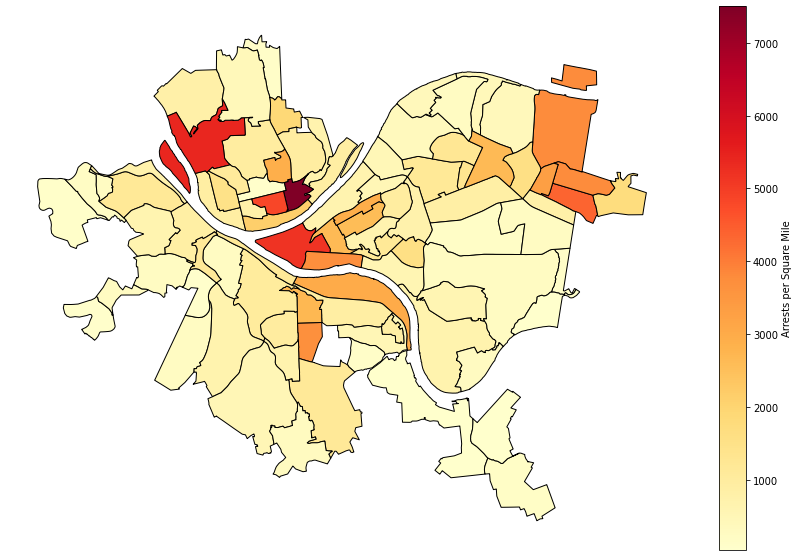

In [19]:
#Arrests Plot
neighborhood_gdf.plot(figsize=(15,10), column = "arrests_sqmile",
                    cmap = "YlOrRd",
                   legend = True,
                   legend_kwds = {"label":"Arrests per Square Mile"},
                   edgecolors = "black")
plt.axis("off")

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

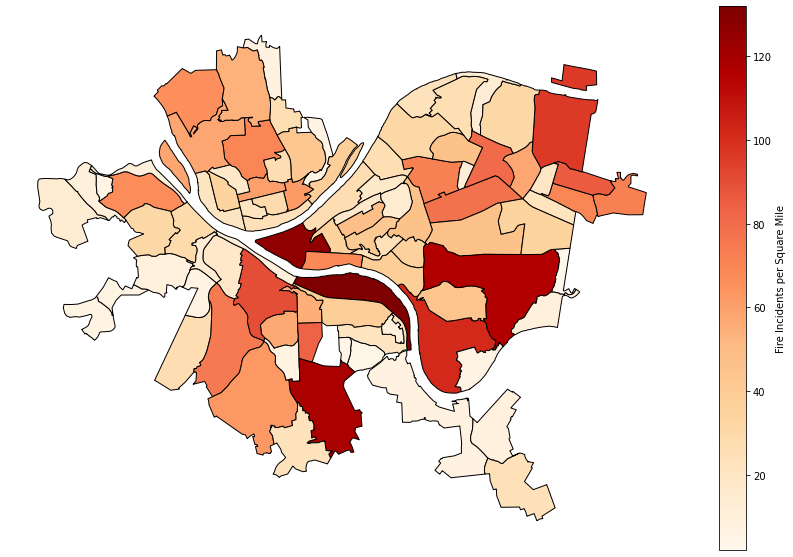

In [16]:
#Fire Incidents Plot
neighborhood_gdf.plot(column='fires',
              cmap='OrRd',            
              edgecolor="black",      
              legend=True,              
              legend_kwds={'label': "Fire Incidents per Square Mile"}, 
              figsize=(15, 10),         
              )
plt.axis("off")

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

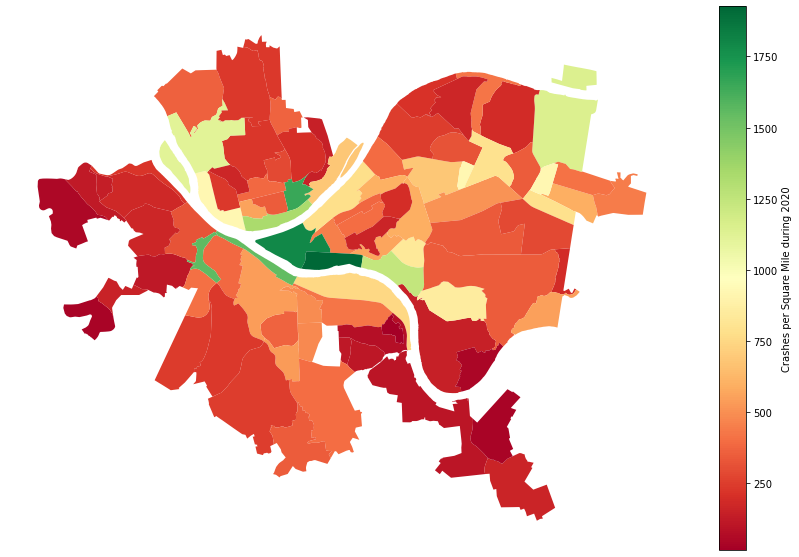

In [9]:
#Crashes Plot
neighborhood_gdf.plot(column='crash_sqmile',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')

In [27]:
max_series = neighborhood_gdf[['arrests_sqmile','fires_sqmile','crashes_sqmile']].max()
neighborhood_gdf = neighborhood_gdf.assign(arrests_1 = lambda x: x['arrests_sqmile'] / max_series['arrests_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(fires_1 = lambda x: x['fires_sqmile'] / max_series['fires_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_1 = lambda x: x['crashes_sqmile'] / max_series['crashes_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(score = lambda x: (x['arrests_1'] + x['fires_1'] + x['crashes_1']) / 3 * 100)

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

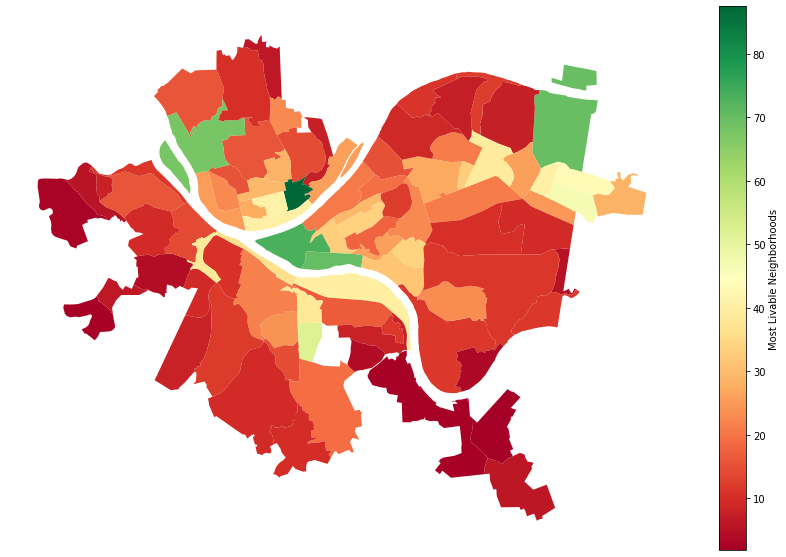

In [38]:
neighborhood_gdf.plot(column='score',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Most Livable Neighborhoods'},
                      figsize=(15,10))
plt.axis('off')

In [29]:
sort_items = list(neighborhood_gdf.sort_values('score', ascending=False)['score'].items())
for i in range(len(sort_items)):
    pair = sort_items[i]
    print(str(i+1) + ". " + pair[0] + " - " + str(int(pair[1])))

1. East Allegheny - 87
2. Central Business District - 73
3. Bluff - 70
4. Lincoln-Lemington-Belmar - 69
5. Marshall-Shadeland - 67
6. Knoxville - 51
7. Homewood South - 46
8. Homewood North - 43
9. Allegheny Center - 40
10. Homewood West - 40
11. North Shore - 40
12. South Side Flats - 40
13. East Liberty - 39
14. Allentown - 38
15. West End - 38
16. South Shore - 36
17. Central Oakland - 34
18. Middle Hill - 33
19. Crawford-Roberts - 33
20. Friendship - 32
21. South Oakland - 31
22. Central Northside - 29
23. Bedford Dwellings - 29
24. East Hills - 28
25. Fineview - 28
26. Allegheny West - 27
27. Bloomfield - 27
28. West Oakland - 25
29. Troy Hill - 25
30. Larimer - 25
31. Chateau - 25
32. Point Breeze North - 24
33. Beltzhoover - 24
34. Greenfield - 22
35. Manchester - 22
36. Northview Heights - 22
37. North Oakland - 22
38. Mount Washington - 21
39. Garfield - 21
40. Shadyside - 21
41. Strip District - 20
42. Polish Hill - 19
43. Carrick - 19
44. Terrace Village - 17
45. South Side 

ValueError: cannot convert float NaN to integer

In [32]:
for index, row in neighborhood_gdf[['arrests','fires','crashes']].iterrows():
    print(index + ": arrests-" + str(row['arrests']) + ", fires-" + str(row['fires']) + ", crashes-" + str(row['crashes']))

Chateau: arrests-361.0, fires-21.0, crashes-352.0
Summer Hill: arrests-60.0, fires-8.0, crashes-102.0
Northview Heights: arrests-593.0, fires-26.0, crashes-116.0
Spring Hill-City View: arrests-605.0, fires-43.0, crashes-131.0
Perry South: arrests-892.0, fires-70.0, crashes-203.0
Fineview: arrests-727.0, fires-27.0, crashes-71.0
Central Northside: arrests-23.0, fires-60.0, crashes-100.0
Spring Garden: arrests-196.0, fires-6.0, crashes-40.0
Troy Hill: arrests-354.0, fires-39.0, crashes-263.0
East Allegheny: arrests-1770.0, fires-62.0, crashes-391.0
Manchester: arrests-420.0, fires-35.0, crashes-65.0
Allegheny West: arrests-109.0, fires-21.0, crashes-78.0
North Shore: arrests-657.0, fires-24.0, crashes-405.0
Allegheny Center: arrests-1014.0, fires-29.0, crashes-73.0
Brighton Heights: arrests-920.0, fires-66.0, crashes-403.0
Marshall-Shadeland: arrests-1253.0, fires-58.0, crashes-258.0
California-Kirkbride: arrests-239.0, fires-17.0, crashes-36.0
Perry North: arrests-532.0, fires-54.0, cra